# Appending columns of case counts for new dates, to pre-existing zip code layers (points and polygons), for the Covid-19 dashboard. Sample.


Steps:

1. Retrieve the current layer from SDCounty dashboard, convert to a DF, convert to 4326, and transform to a DF by zip codes (using Pivot), resulting in a wide table

2. Save as a CSV file, making sure that **zipcode** in this file is a text column. Then add this file to AGOL. This will be the **source** file. 

3. Reference pre-existing zip code layers, both point and polygon. These are the **target** layers. These layers shall have a **ZIP** column, that will be used for joining data from the source. These layers should also have non-editable view layers, to be referenced from the dashboard. 

4. Figure out which fields from the source layer to add to the target layer, and then join them



In [75]:
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection
from arcgis.features import FeatureLayer
import pandas as pd
import json
from copy import deepcopy
import time
gis = GIS(username='xij080_ucsd5')  # this will ask for password. 
arcgis.__version__

Enter password: ········


'1.8.1'

## 1. Retrieve the current layer from SDCounty dashboard, convert to a DF, convert to 4326, and transform to a DF by zip codes (using Pivot), resulting in a wide table



In [185]:
sd_dashboard_service = 'https://services1.arcgis.com/1vIhDJwtG5eNmiqX/ArcGIS/rest/services/CovidDashUpdate/FeatureServer'
db_item = FeatureLayerCollection(sd_dashboard_service)
ZipsCompiled_df = pd.DataFrame.spatial.from_layer(db_item.layers[0])
# ConfirmHopsitalICuDeaths_df = pd.DataFrame.spatial.from_layer(db_item.layers[1])
# AgeGenderPoints_df = pd.DataFrame.spatial.from_layer(db_item.layers[2])
# CompiledCopyDashUpdate_df = pd.DataFrame.spatial.from_layer(db_item.layers[3])
# db_item.layers[0]

In [186]:
# convert the layer with counts by zips into a df, in 4326

ZipsCompiled_df_4326 = db_item.layers[0].query(out_sr = 4326, return_geometry=True).sdf


In [187]:
ZipsCompiled_df_4326.head()

,OBJECTID,SDEP_SANGIS_ZIPCODE_ZIP,ZipText,Zip_Code,Case_Count,UpdateDate,rate_100k,SHAPE
0,227,91901,91901,None,1.0,2020-04-01 08:00:00,None,"{""x"": -116.69553702167843, ""y"": 32.80570970685..."
1,228,91902,91902,91902,9.0,2020-04-01 08:00:00,None,"{""x"": -117.01506766053788, ""y"": 32.67158293810..."
2,229,91910,91910,91910,23.0,2020-04-01 08:00:00,None,"{""x"": -117.0656532926161, ""y"": 32.636413417033..."
3,230,91911,91911,91911,21.0,2020-04-01 08:00:00,None,"{""x"": -117.05021424270026, ""y"": 32.60730912252..."
4,231,91913,91913,91913,20.0,2020-04-01 08:00:00,None,"{""x"": -116.98749464783407, ""y"": 32.61626743309..."


In [188]:
# create the X and Y columns in this df. There is probably a better way to do this

for idx, row in ZipsCompiled_df_4326.iterrows():
    
    a = str(ZipsCompiled_df_4326.loc[idx,'SHAPE']).replace("'", '"')
    js = json.loads(a)
    ZipsCompiled_df_4326.loc[idx,'X'] =  js['x']
    ZipsCompiled_df_4326.loc[idx,'Y'] =  js['y']



In [189]:
# save only necessary columns into a csv file ZipsCompiled_df_4326_timestamp.csv, for service update. This is a complete current file

import csv
ts = time.gmtime()
currentfile = 'ZipsCompiled_df_4326_'+time.strftime("%Y%m%d_%H_%M_%S", ts) +'.csv'


# a really hacky way to force ZipText to be a string...

ZipsCompiled_df_4326_for_csv = ZipsCompiled_df_4326.copy()

ZipsCompiled_df_4326_for_csv['ZipText'] = ZipsCompiled_df_4326_for_csv['ZipText'].astype(str)

aa = ZipsCompiled_df_4326_for_csv.loc[0]['ZipText']
bb = "'" + aa + "'"
ZipsCompiled_df_4326_for_csv.loc[0,'ZipText'] = bb


ZipsCompiled_df_4326_for_csv.to_csv(currentfile,columns=['ZipText','Case_Count','UpdateDate','X','Y'], quotechar='"', quoting=csv.QUOTE_MINIMAL, index=False)

### Now, create a wide table and rename columns
    

In [190]:
ZipsCompiled_df_4326

,OBJECTID,SDEP_SANGIS_ZIPCODE_ZIP,ZipText,Zip_Code,Case_Count,UpdateDate,rate_100k,SHAPE,X,Y
0,227,91901,91901,None,1.0,2020-04-01 08:00:00,None,"{""x"": -116.69553702167843, ""y"": 32.80570970685...",-116.695537,32.805710
1,228,91902,91902,91902,9.0,2020-04-01 08:00:00,None,"{""x"": -117.01506766053788, ""y"": 32.67158293810...",-117.015068,32.671583
2,229,91910,91910,91910,23.0,2020-04-01 08:00:00,None,"{""x"": -117.0656532926161, ""y"": 32.636413417033...",-117.065653,32.636413
3,230,91911,91911,91911,21.0,2020-04-01 08:00:00,None,"{""x"": -117.05021424270026, ""y"": 32.60730912252...",-117.050214,32.607309
4,231,91913,91913,91913,20.0,2020-04-01 08:00:00,None,"{""x"": -116.98749464783407, ""y"": 32.61626743309...",-116.987495,32.616267
...,...,...,...,...,...,...,...,...,...,...
11130,11658,92173,92173,92173,610.0,2020-07-07 08:00:00,None,"{""x"": -117.04751282860981, ""y"": 32.55423241302...",-117.047513,32.554232
11131,11659,92182,92182,None,NaN,2020-07-07 08:00:00,None,"{""x"": -117.07331074395721, ""y"": 32.77618219510...",-117.073311,32.776182
11132,11660,92259,92259,None,NaN,2020-07-07 08:00:00,None,"{""x"": -116.15392566169824, ""y"": 32.76589531810...",-116.153926,32.765895
11133,11661,92536,92536,None,NaN,2020-07-07 08:00:00,None,"{""x"": -116.7205466770345, ""y"": 33.398676103540...",-116.720547,33.398676


In [193]:
# generate better time stamps
ZipsCompiled_df_4326['DateString'] = ZipsCompiled_df_4326['UpdateDate']
ZipsCompiled_df_4326['DateString'] = ZipsCompiled_df_4326['DateString'].dt.strftime("%m/%d/%y")
ZipsCompiled_df_4326

,OBJECTID,SDEP_SANGIS_ZIPCODE_ZIP,ZipText,Zip_Code,Case_Count,UpdateDate,rate_100k,SHAPE,X,Y,DateString
0,227,91901,91901,None,1.0,2020-04-01 08:00:00,None,"{""x"": -116.69553702167843, ""y"": 32.80570970685...",-116.695537,32.805710,04/01/20
1,228,91902,91902,91902,9.0,2020-04-01 08:00:00,None,"{""x"": -117.01506766053788, ""y"": 32.67158293810...",-117.015068,32.671583,04/01/20
2,229,91910,91910,91910,23.0,2020-04-01 08:00:00,None,"{""x"": -117.0656532926161, ""y"": 32.636413417033...",-117.065653,32.636413,04/01/20
3,230,91911,91911,91911,21.0,2020-04-01 08:00:00,None,"{""x"": -117.05021424270026, ""y"": 32.60730912252...",-117.050214,32.607309,04/01/20
4,231,91913,91913,91913,20.0,2020-04-01 08:00:00,None,"{""x"": -116.98749464783407, ""y"": 32.61626743309...",-116.987495,32.616267,04/01/20
...,...,...,...,...,...,...,...,...,...,...,...
11130,11658,92173,92173,92173,610.0,2020-07-07 08:00:00,None,"{""x"": -117.04751282860981, ""y"": 32.55423241302...",-117.047513,32.554232,07/07/20
11131,11659,92182,92182,None,NaN,2020-07-07 08:00:00,None,"{""x"": -117.07331074395721, ""y"": 32.77618219510...",-117.073311,32.776182,07/07/20
11132,11660,92259,92259,None,NaN,2020-07-07 08:00:00,None,"{""x"": -116.15392566169824, ""y"": 32.76589531810...",-116.153926,32.765895,07/07/20
11133,11661,92536,92536,None,NaN,2020-07-07 08:00:00,None,"{""x"": -116.7205466770345, ""y"": 33.398676103540...",-116.720547,33.398676,07/07/20


In [192]:
# generate a wide table for the current file. This will be a source datatable for updating zip code layers
zips_wide_df = ZipsCompiled_df_4326.pivot(index='ZipText', columns='DateString', values='Case_Count')

ValueError: Index contains duplicate entries, cannot reshape

In [171]:
# zips_wide_df['zipcode'] = zips_wide_df['ZipText']
zips_wide_df['zipcode'] = zips_wide_df.index
#zips_wide_df.reset_index(inplace=True)
zips_wide_df

DateString,03/30/20,03/31/20,04/01/20,04/02/20,04/03/20,04/04/20,04/05/20,04/06/20,04/07/20,04/08/20,...,06/27/20,06/28/20,06/29/20,06/30/20,07/01/20,07/02/20,07/03/20,07/04/20,07/05/20,zipcode
ZipText,,,,,,,,,,,,,,,,,,,,,
91901,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,25.0,25.0,26.0,26.0,29.0,31.0,32.0,34.0,35.0,91901
91902,8.0,8.0,9.0,10.0,10.0,11.0,11.0,14.0,16.0,16.0,...,65.0,68.0,71.0,73.0,77.0,79.0,84.0,92.0,94.0,91902
91905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,91905
91906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,7.0,7.0,7.0,8.0,8.0,9.0,9.0,91906
91910,17.0,21.0,23.0,28.0,28.0,30.0,30.0,34.0,39.0,43.0,...,575.0,599.0,615.0,643.0,661.0,686.0,696.0,726.0,732.0,91910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92173,5.0,7.0,8.0,12.0,13.0,17.0,17.0,18.0,20.0,21.0,...,520.0,536.0,542.0,548.0,557.0,563.0,569.0,583.0,595.0,92173
92182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92182
92259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92259


## 2. Save as a CSV file, making sure that "zipcode" in this file is a text column. Then add this file to AGOL. This will be the source file. 

In [172]:
zips_wide_df_for_csv

DateString,ZipText,03/30/20,03/31/20,04/01/20,04/02/20,04/03/20,04/04/20,04/05/20,04/06/20,04/07/20,...,06/27/20,06/28/20,06/29/20,06/30/20,07/01/20,07/02/20,07/03/20,07/04/20,07/05/20,zipcode
0,91901,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,25.0,25.0,26.0,26.0,29.0,31.0,32.0,34.0,35.0,91901
1,91902,8.0,8.0,9.0,10.0,10.0,11.0,11.0,14.0,16.0,...,65.0,68.0,71.0,73.0,77.0,79.0,84.0,92.0,94.0,91902
2,91905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,91905
3,91906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,7.0,7.0,7.0,8.0,8.0,9.0,9.0,91906
4,91910,17.0,21.0,23.0,28.0,28.0,30.0,30.0,34.0,39.0,...,575.0,599.0,615.0,643.0,661.0,686.0,696.0,726.0,732.0,91910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,92173,5.0,7.0,8.0,12.0,13.0,17.0,17.0,18.0,20.0,...,520.0,536.0,542.0,548.0,557.0,563.0,569.0,583.0,595.0,92173
109,92182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92182
110,92259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92259
111,92536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92536


In [178]:
widefile = 'ZipsWide_'+time.strftime("%Y%m%d_%H_%M_%S", ts) +'.csv'

zips_wide_df_for_csv = zips_wide_df.copy()
aa = zips_wide_df_for_csv.loc['91901']['zipcode']
bb = "'" + aa + "'"
zips_wide_df_for_csv.loc['91901','zipcode'] = bb

zips_wide_df_for_csv['zipcode'][0] = '91901'
zips_wide_df_for_csv.to_csv(widefile,quotechar='"', quoting=csv.QUOTE_MINIMAL, index=False)


# add the current csv file to AGOL:
# zip_wide_props = {'title':'Updated zips_wide just downloaded '+time.strftime("%Y%m%d_%H_%M_%S", ts)}
# csv_wide_item = gis.content.add(item_properties=zip_wide_props, data=widefile)
# csv_wide_item 

/Users/xingyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Item title:"Updated zips_wide just downloaded20200707_04_02_59" type:CSV owner:xij080_ucsd5>

In [175]:
# we'll need *zip_wide_csv_info* in the last step, when appending a new column
zip_wide_csv_info = gis.content.analyze(item=csv_wide_item.id, file_type='csv', location_type='none')
#check the last updated date 
zip_wide_csv_info['publishParameters']['layerInfo']['fields'][-2]

{'name': '07_05_20',
 'type': 'esriFieldTypeDouble',
 'alias': '07/05/20',
 'sqlType': 'sqlTypeFloat',
 'nullable': True,
 'editable': True,
 'domain': None,
 'defaultValue': None,
 'locationType': 'unknown'}

In [110]:
# list the fields in the updated file. Eventually, this will be needed to figure out which of these fields to add
csv_name=[]
csv_to_be_add=[]
for csv_field in zip_wide_csv_info['publishParameters']['layerInfo']['fields']:
    csv_name.append(csv_field['name'])
csv_name=[i.replace('_','/') for i in csv_name]
for i in zips_wide_df_for_csv.columns:
    if i not in csv_name:
        csv_to_be_add.append(i)
csv_to_be_add=[i.replace('/','_') for i in csv_to_be_add]
csv_name=[i.replace('/','_') for i in csv_name]
csv_name.remove('zipcode')

['03_30_20',
 '03_31_20',
 '04_01_20',
 '04_02_20',
 '04_03_20',
 '04_04_20',
 '04_05_20',
 '04_06_20',
 '04_07_20',
 '04_08_20',
 '04_09_20',
 '04_10_20',
 '04_11_20',
 '04_12_20',
 '04_13_20',
 '04_14_20',
 '04_15_20',
 '04_16_20',
 '04_17_20',
 '04_18_20',
 '04_19_20',
 '04_20_20',
 '04_21_20',
 '04_22_20',
 '04_23_20',
 '04_24_20',
 '04_25_20',
 '04_26_20',
 '04_27_20',
 '04_28_20',
 '04_29_20',
 '04_30_20',
 '05_01_20',
 '05_02_20',
 '05_03_20',
 '05_04_20',
 '05_05_20',
 '05_06_20',
 '05_07_20',
 '05_08_20',
 '05_09_20',
 '05_10_20',
 '05_11_20',
 '05_12_20',
 '05_13_20',
 '05_14_20',
 '05_15_20',
 '05_16_20',
 '05_17_20',
 '05_18_20',
 '05_19_20',
 '05_20_20',
 '05_21_20',
 '05_22_20',
 '05_23_20',
 '05_24_20',
 '05_25_20',
 '05_26_20',
 '05_27_20',
 '05_28_20',
 '05_29_20',
 '05_30_20',
 '05_31_20',
 '06_01_20',
 '06_02_20',
 '06_03_20',
 '06_04_20',
 '06_05_20',
 '06_06_20',
 '06_07_20',
 '06_08_20',
 '06_09_20',
 '06_10_20',
 '06_11_20',
 '06_12_20',
 '06_13_20',
 '06_14_20',

## 3. Reference pre-existing zip code layers, both point and polygon. 

These are the **target** feature layers. These layers shall have a **ZIP** column, that will be used for joining data from the source. These layers should also have non-editable view layers, to be referenced from the dashboard. 



In [111]:
zip_point_base_fl = gis.content.get('9f2f382638ad497187683216f899b7c9')
zip_poly_base_fl = gis.content.get('f595732fd52342108cca7a487087d5c5')

## 4. Figure out which fields from the source layer to add to the target layer, and then join them

In [115]:
# let's do it with a point layer, as a demonstration

# see which fields are already included in the target layer

zip_point_lyr = zip_point_base_fl.layers[0]
point_name=[]
point_field_list=[]
new_dates=[]

for field in zip_point_lyr.properties.fields:
    point_name.append(field['name'])

for i in csv_name:
    if i not in point_name:
        new_dates.append(i)
        dols_field = dict(deepcopy(zip_point_lyr.properties.fields[1]))
        dols_field['name'] = i
        dols_field['alias'] = i
        dols_field['type'] = "esriFieldTypeDouble"
        point_field_list.append(dols_field)
        
#  Update feature layer definition with the new field using the add_to_definition() method.
zip_point_lyr.manager.add_to_definition({"fields":point_field_list})

{'success': True}

In [180]:
# samething to do with polygon layer
zip_poly_lyr = zip_poly_base_fl.layers[0]
poly_name=[]
poly_field_list=[]

for field in zip_poly_lyr.properties.fields:
    poly_name.append(field['name'])

for i in csv_name:
    if i not in poly_name:
        dols_field = dict(deepcopy(zip_poly_lyr.properties.fields[1]))
        dols_field['name'] = i
        dols_field['alias'] = i
        dols_field['type'] = "esriFieldTypeDouble"
        poly_field_list.append(dols_field)
        
# zip_poly_lyr.manager.add_to_definition({"fields":poly_field_list})         

In [116]:
# check if it has been added Ok
# for field in gis.content.get('9f2f382638ad497187683216f899b7c9').layers[0].properties.fields:
#     print(f"{field['name']:30}{field['type']}")

In [117]:
# create indexes based on ZIP (can skip this cell, it is only needed once)


# uk_name_idx = dict(deepcopy(zip_point_lyr.properties['indexes'][0]))
# uk_name_idx['name'] = 'c_ZIP_uk'
# uk_name_idx['fields'] = 'ZIP'
# uk_name_idx['isUnique'] = True
# uk_name_idx['description'] = 'index_name'

# uk_name_idx


In [118]:
# index_list = [uk_name_idx]
# zip_point_lyr.manager.add_to_definition({"indexes":index_list})

In [119]:
# Verify the index was added
# uk_flds = [f.fields.lower() for f in gis.content.get('9f2f382638ad497187683216f899b7c9').layers[0].properties.indexes if f.isUnique]

# for fld in zip_point_lyr.properties.fields:
#     if fld.name.lower() in uk_flds:
#         print(f"{fld.name:30}{fld.type:25}isUnique")
#     else:
#         print(f"{fld.name:30}{fld.type:25}")

In [179]:
# append attribute values

# here: 
# ZIP is the column name in the target layer that is used for the join. 
#      It is also an index, as established in the previous cell.
#      It is a text column with field definition matching zipcode column in the source file
#  
# zipcode is the matching column in the source layer. 
#
# 07_01_20 is a column name in both source and target (Double, in both cases) 
#
#
implement=new_dates
for i in implement:
    zip_point_lyr.append(item_id=csv_wide_item.id,
                          upload_format = 'csv',
                          field_mappings = [{"name":i, "source":i},
                                            {"name":"ZIP", "source":"zipcode"}],
                          source_info = zip_wide_csv_info['publishParameters'],
                          upsert=True,
                          update_geometry=False,
                          append_fields=[i, "ZIP"],
                          skip_inserts=True,
                          upsert_matching_field="ZIP")
    print('done for '+ i)

In [ ]:
implement=new_dates
for i in implement:
    zip_poly_lyr.append(item_id=csv_wide_item.id,
                          upload_format = 'csv',
                          field_mappings = [{"name":i, "source":i},
                                            {"name":"ZIP", "source":"zipcode"}],
                          source_info = zip_wide_csv_info['publishParameters'],
                          upsert=True,
                          update_geometry=False,
                          append_fields=[i, "ZIP"],
                          skip_inserts=True,
                          upsert_matching_field="ZIP")
    print('done for '+ i)

In [ ]:
# check the result

zip_point_lyr = gis.content.get('9f2f382638ad497187683216f899b7c9').layers[0]
zip_point_lyr_df = zip_point_lyr.query(as_df=True)
zip_point_lyr_df

<Item title:"SanDiego CoVID-19 Cases Dashboard" type:Dashboard owner:yim095_UCSDOnline>
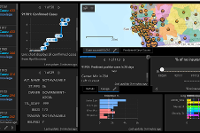

In [184]:
dashboard=gis.content.get('7d558aeee4aa460b9f236620c8ee59a0')
display(dashboard)